<a href="https://colab.research.google.com/github/drewwint/ABCD_subset_project/blob/main/DDC_simulation_verify_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dynamic Differnetial Covariance for Python
## Code to calcualte DDC - both linear and non-linear as well as their regularized forms in Python
## Demonstration below validates this code with a similation for timeseries signal recovery
#### Written by: Drew E. Winters, PhD.

## packages

In [317]:
import sys
from IPython.utils import io
if 'google.colab' in sys.modules:

  with io.capture_output() as captured:
      ! pip install watermark

In [318]:
import pandas as pd
import numpy as np
from scipy import stats
import os, glob, pathlib
import re # to manupulate varaibles
from sklearn.linear_model import Ridge
from numpy.linalg import inv, matrix_rank
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import Ridge
from scipy.stats import zscore


In [319]:
seed = 5489 # set seed for reproducibility
  ## according to <https://walkingrandomly.com/?p=5480> this is the same as matlab default twister 0 "rng(0)""
np.random.seed(seed)

# Functions

## Non-linear timeseries simulation function

ReLU nonlinearity
Simulation iteration: 0.10
Simulation iteration: 0.20
Simulation iteration: 0.30
Simulation iteration: 0.40
Simulation iteration: 0.50
Simulation iteration: 0.60
Simulation iteration: 0.70
Simulation iteration: 0.80
Simulation iteration: 0.90


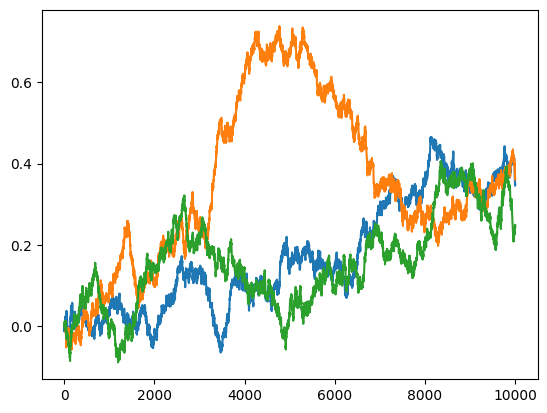

In [320]:

def nonlinear_simulation(G, deltaT, RandInput, options):
    """
    Simulate the dynamics of a nonlinear system.

    Parameters:
    - G (numpy.ndarray): Connectivity matrix.
    - deltaT (float): Integration step.
    - RandInput (float): Magnitude of noisy input.
    - options (dict): Dictionary with keys 'nonlinearity', 'parameter', and 'Ttotal'.

    Returns:
    - V_pre (numpy.ndarray): Time points x variables.
    """

    def relu(x, param):
        """ReLU activation function with a given parameter."""
        Fx = x - param
        Fx[Fx < 0] = 0
        return Fx

    def sigmoid(x, param):
        """Sigmoid activation function with a given parameter."""
        return 1 / (1 + np.exp(-param * x))

    def sigmoid_sym(x, param):
        """Symmetric sigmoid activation function with a given parameter."""
        return 1 / (1 + np.exp(-param * x)) - 0.5

    # Select the nonlinearity function based on options
    if options['nonlinearity'] == 'relu':
        print('ReLU nonlinearity')
        F = lambda x: relu(x, options['parameter'])
    elif options['nonlinearity'] == 'sigmoid':
        print('Sigmoid nonlinearity')
        F = lambda x: sigmoid(x, options['parameter'])
    elif options['nonlinearity'] == 'sigmoid_sym':
        print('Sigmoid symmetric nonlinearity')
        F = lambda x: sigmoid_sym(x, options['parameter'])
    else:
        raise ValueError("Unsupported nonlinearity function")

    N = G.shape[0]
    T = int(options['Ttotal'] / deltaT)  # Number of time steps
    V_pre = np.zeros((T, N))
    I = np.zeros((T, N))

    for t in range(1, T):
        u = np.random.randn(N) * RandInput
        I[t, :] = (G @ F(V_pre[t-1, :]))  # Matrix-vector multiplication
        V_pre[t, :] = V_pre[t-1, :] + (I[t, :] + u) * deltaT

        if np.any(V_pre[t, :] > 10000):
            print('Simulation exploded')
            break

        if t % (T // 10) == 0:
            print(f'Simulation iteration: {t / T:.2f}')

    return V_pre

# Estimating data
G = np.array([[0, -0.5, -0.5],
              [-0.5, 0, 0.5],
              [-0.5, 0.5, 0]])
deltaT = 0.1
RandInput = 0.04
options = {
    'nonlinearity': 'relu',  # 'sigmoid' or 'sigmoid_sym'
    'parameter': 1,
    'Ttotal': 1000
}

V_pre = nonlinear_simulation(G, deltaT, RandInput, options)

# Plotting the results
import matplotlib.pyplot as plt

plt.plot(V_pre)
plt.show()


In [321]:
pd.DataFrame(V_pre).shape

(10000, 3)

## Code for the relu estimation

###### [Translated from](https://github.com/yschen13/DDC/tree/main)

###### Because [this code’s](https://github.com/margotwagner/DDC/blob/main/src/py_DDC/Compute_DDC.py) early thresholding on the raw data, followed by a separate regularization step, likely distorts the signal and leads to poorer recovery, We improved on the implemnetation here and substantially improved speed and recovery (see example comparing our codes performance at the end of the notebook)
- See these [cells](https://colab.research.google.com/drive/1-ZwexznRlUmSgtitbPJVX7Rh8R15cn7n#scrollTo=rOXD612XMDby&line=2&uniqifier=1) for code performance comparision
- See this [cell](https://colab.research.google.com/drive/1-ZwexznRlUmSgtitbPJVX7Rh8R15cn7n#scrollTo=32rTU4N9gmmy&line=4&uniqifier=1) for indepth explaination for why this code here works better

In [322]:


def derivative_123(f, dm, dt):
    """
    Compute the first, second, and third derivatives of a function.
    Parameters:
    - f (numpy.ndarray): Array of function values.
    - dm (int): Parameter for the derivative calculation.
    - dt (float): Time step size.
    Returns:
    - D1 (numpy.ndarray): First derivative.
    - D2 (numpy.ndarray): Second derivative.
    - D3 (numpy.ndarray): Third derivative.
    """
    t = np.arange(1 + dm, len(f) - dm)
    # for this function to work f has to be a numpy array
    f = np.array(f)
    # D1 (First Derivative)
    D1 = 0
    d = 0
    for n1 in range(1, dm + 1):
        for n2 in range(n1 + 1, dm + 1):
            d += 1
            numerator = -((f[t - n2] * n1**3 - f[t + n2] * n1**3 -
                f[t - n1] * n2**3 + f[t + n1] * n2**3))
            denominator = (2 * dt * n1**3 * n2 - 2 * dt * n1 * n2**3)
            D1 += numerator / denominator
    D1 /= d

    # D2 (Second Derivative)
    D2 = 0
    d = 0
    for n1 in range(1, dm + 1):
        for n2 in range(n1 + 1, dm + 1):
            d += 1
            numerator = (f[t - n2] * n1**4 + f[t + n2] * n1**4 -
                         f[t - n1] * n2**4 - f[t + n1] * n2**4 -
                         2 * f[t] * (n1**4 - n2**4))
            denominator = (dt**2 * n2**2 * (n1**4 - n1**2 * n2**2))
            D2 += numerator / denominator
    D2 /= d

    # D3 (Third Derivative)
    D3 = 0
    d = 0
    for n1 in range(1, dm + 1):
        for n2 in range(n1 + 1, dm + 1):
            for n3 in range(n2 + 1, dm + 1):
                d += 1
                numerator = (3 * (f[t - n3] * n1 * n2 * (n1**4 - n2**4) +
                                  f[t + n3] * (-n1**5 * n2 + n1 * n2**5) +
                                  n3 * ((f[t - n1] - f[t + n1]) * n2 * (n2**4 - n3**4) +
                                        f[t + n2] * (n1**5 - n1 * n3**4) +
                                        f[t - n2] * (-n1**5 + n1 * n3**4))))
                denominator = (dt**3 * n1 * (n1**2 - n2**2) * n3 * (n1**2 - n3**2) * (n2**3 - n2 * n3**2))
                D3 += numerator / denominator

    D3 /= d
    return D1, D2, D3



def dCov_numerical(cx, h, dm=4):
  """
  Compute various numerical differential covariance matrices using different finite difference methods (derivative approximations).

  Parameters:
  - cx (numpy.ndarray): Time series data matrix (T x N).
  - h (float): Step size for numerical differentiation.
  - dm (int, optional): Maximum window size for custom derivative computation. Default is 4.

  Returns:
  - dCov1 (numpy.ndarray): Differential covariance using first difference method (N x N) [approximation of first derivatie].
  - dCov2 (numpy.ndarray): Differential covariance using central difference method (N x N) [approximation of second derivative].
  - dCov5 (numpy.ndarray): Differential covariance using a higher-order difference method (N x N) [approximation of five-point stencil approximation].
  - dCov_center (numpy.ndarray): Differential covariance using a custom centered method (N x N) [the centered derivative from Taylor expansion].

  NOTE:
  	dCov = <dv/dt,v>
  	covariance is computed through np.cov()
  """
  T, N = cx.shape
  # Compute first-order derivative
  cx = np.array(cx)
  diff_cx = np.vstack(((cx[1:, :] - cx[:-1, :]) / h,
                       np.mean(cx[1:, :] - cx[:-1, :], axis=0)))
  Csample = np.cov(np.hstack((diff_cx, cx)).T, rowvar=False)
  dCov1 = zscore(Csample[:N, N:N + N])

  # Compute second-order derivative
  diff_cx = np.vstack(((1/2 * cx[2:, :] - 1/2 * cx[:-2, :]) / h,
                       np.mean(1/2 * cx[2:, :] - 1/2 * cx[:-2, :], axis=0),
                       diff_cx[-1, :]))
  Csample = np.cov(np.hstack((diff_cx, cx)), rowvar=False)
  dCov2 = zscore(Csample[:N, N:N + N])

  # Compute five-point stencil derivative
  diff_cx = np.zeros((T, N))
  for i in range(2, T - 2):
      for j in range(2, N - 2):
        diff_cx[i, j] = (
            -cx[i + 2, j] + 8 * cx[i + 1, j]
            - 8 * cx[i - 1, j] + cx[i - 2, j]
        ) / 12.0
  Csample = np.cov(np.hstack((diff_cx, cx)), rowvar=False)
  dCov5 = Csample[:N, N:N + N]

  # Compute centered derivative using derivative_123
  diff_cx = np.zeros(((T - 2 * dm)-1, N))
  for i in range(N):
      dx, _, _ = derivative_123(cx[:, i], dm, h)
      diff_cx[:, i] = dx
  cx_trunc = cx[1+dm:T - dm, :]
  Csample = np.cov(np.hstack((diff_cx, cx_trunc)), rowvar=False)
  dCov_center = Csample[:N, N:N + N]

  return dCov1, dCov2, dCov5, dCov_center


def estimators(V, thres, TR):
  """
	INPUT:
  		V_obs: time points x variables
  		thres: Relu offset
  		TR: sampling interval (seconds)
  OUTPUT:
  		B: ReLu(x),x
  		dCov: dx/dt,x
  """
  T, N = V.shape
  V_obs = zscore(V, axis=0)
  Cov = np.cov(V_obs, rowvar=False)
  precision = np.linalg.inv(Cov)
  # ReLU transformation
  Fx = np.maximum(V_obs - thres, 0)
  B = np.cov(Fx,rowvar=False)
  dV = np.diff(V_obs) / TR
  dV = np.vstack([np.mean(dV, axis=0), dV[1:-1], np.mean(dV, axis=0)])
  dCov = np.cov(np.hstack([dV, V_obs]), rowvar=False)

  return Cov, precision, B, dCov


def dCov_linear_Reg(V, TR, lambda_=0.01):
    """
    L2 Regularized version of deltaL.

    Parameters:
    - V (numpy.ndarray): Time series data (T x N).
    - TR (float): Sampling interval.
    - lambda_ (float): Regularization strength.

    Returns:
    - Delta_L (numpy.ndarray): Linear DDC with ridge regularization.
    """
    T, N = V.shape

    # Standardize V
    V_obs = zscore(V, axis=0)

    # Calculate numerical derivatives and estimators
    _, dCov2, _, _ = dCov_numerical(V_obs, TR)
    Cov, _, _, _ = estimators(V_obs, 0, TR)

    # Use Cov for B as per the MATLAB code
    B = Cov
    C = dCov2

    # Initialize the output matrix
    Delta_L = np.zeros_like(C)

    # Perform ridge regression for each row of C
    BtB_reg_inv = np.linalg.inv(B.T @ B + lambda_ * np.eye(B.shape[1]))
    Delta_L = (zscore(np.flipud((BtB_reg_inv @ B.T @ C.T).T))/(N-1))

    return Delta_L


def dcov_relu(V, TR, lambda_=0.01):
    """
    Regularized version of Delta_ReLU
    INPUT:
        V: time series
        TR: sampling interval
        lambda_: regularization strength
    OUTPUT:
        Delta_ReLU: nonlinear DDC with ReLU nonlinearity
    """
    T, N = V.shape

    # Standardize V
    V_obs = zscore(V, axis=0)

    # Calculate numerical derivatives and estimators
    _, dCov2, _, _ = dCov_numerical(V_obs, TR)

    # Apply ReLU non-linearity to the standardized observations
    V_relu = np.maximum(V_obs, 0)  # Applying ReLU

    # Re-compute the estimators using ReLU-transformed data
    Cov, _, B, _ = estimators(V_relu, 1, TR)

    # Ridge regression using the ReLU-transformed covariance matrix
    BtB_reg_inv = np.linalg.inv(B.T @ B + lambda_ * np.eye(B.shape[1]))
    Delta_ReLU = (zscore(np.flipud((BtB_reg_inv @ B.T @ dCov2.T).T))/(N-1))

    return Delta_ReLU


# Testing the estimation by trying to recover ground truth

## Ground truth figure we are trying to recover


Text(0.5, 1.0, 'Ground Truth')

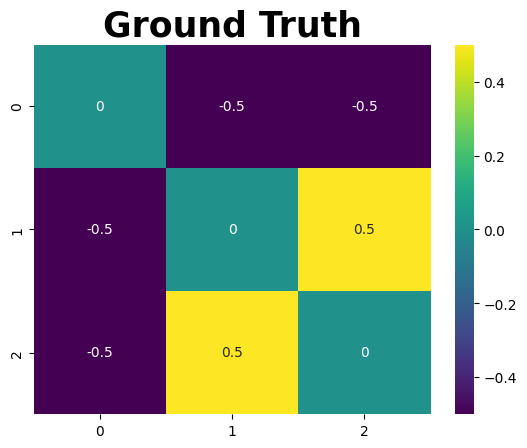

In [323]:
import seaborn as sns
import matplotlib.pyplot as plt
np.fill_diagonal(G,0)
sns.heatmap(G, annot=True, cmap = 'viridis', vmin=-0.5, vmax=0.5)
plt.title('Ground Truth', fontsize=25, fontweight= "bold")

## Correlation Recovery

Text(0.5, 1.0, 'Ground Truth')

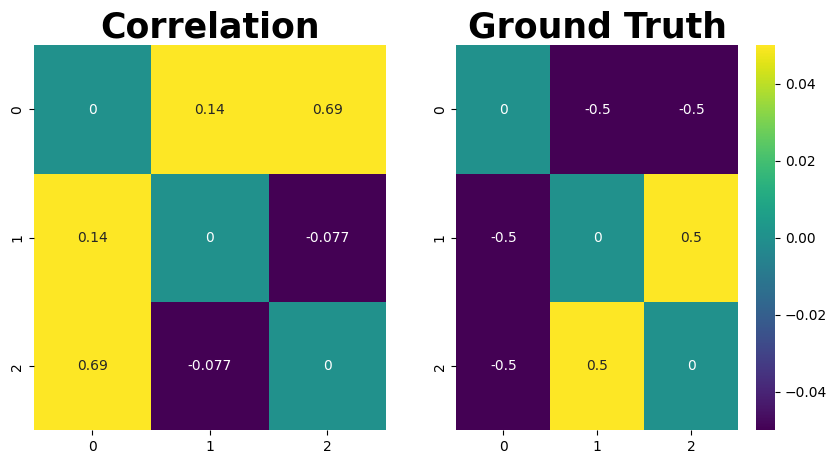

In [324]:
cor = pd.DataFrame(V_pre).corr()
np.fill_diagonal(cor.values,0)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(np.round(cor,3), annot=True, cmap = 'viridis', vmin=-0.05, vmax=0.05, cbar = False, ax=axes[0])
axes[0].set_title("Correlation", fontweight = "bold", fontsize = 25)
sns.heatmap(np.round(G,3), annot=True, cmap = 'viridis', vmin=-0.05, vmax=0.05, ax=axes[1])
axes[1].set_title("Ground Truth", fontweight = "bold", fontsize = 25)

the correlation matrix did a poor job of recovery

### Delta L Recovery

In [325]:
dCov1, dCov2,_,dCovC = dCov_numerical(V_pre, deltaT)
Cov,Precision,B,_ = estimators(V_pre, np.percentile(V_pre,50), deltaT)

Text(0.5, 1.0, 'Ground Truth')

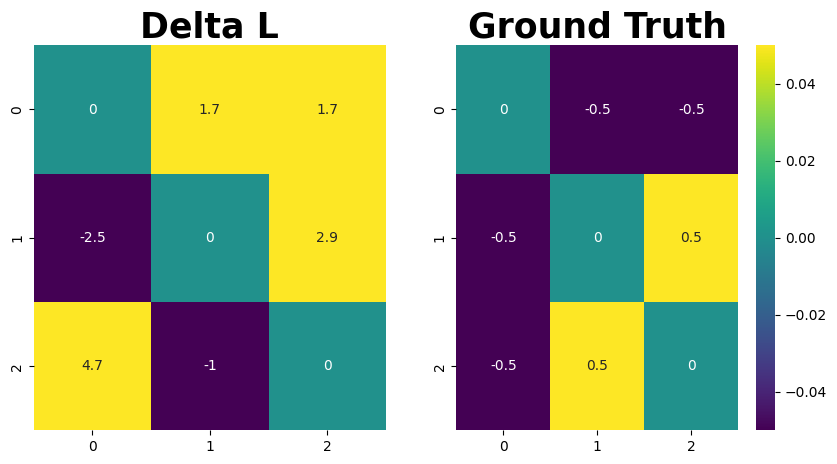

In [326]:
delta_l = np.matmul(dCov2,Precision)
delta_l_p = delta_l.copy()
np.fill_diagonal(delta_l_p,0)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(np.round(delta_l_p,3), annot=True, cmap = 'viridis', vmin=-0.05, vmax=0.05, cbar = False, ax=axes[0])
axes[0].set_title("Delta L", fontweight = "bold", fontsize = 25)
sns.heatmap(np.round(G,3), annot=True, cmap = 'viridis', vmin=-0.05, vmax=0.05, ax=axes[1])
axes[1].set_title("Ground Truth", fontweight = "bold", fontsize = 25)


### Delta Relu Recovery

Text(0.5, 1.0, 'Ground Truth')

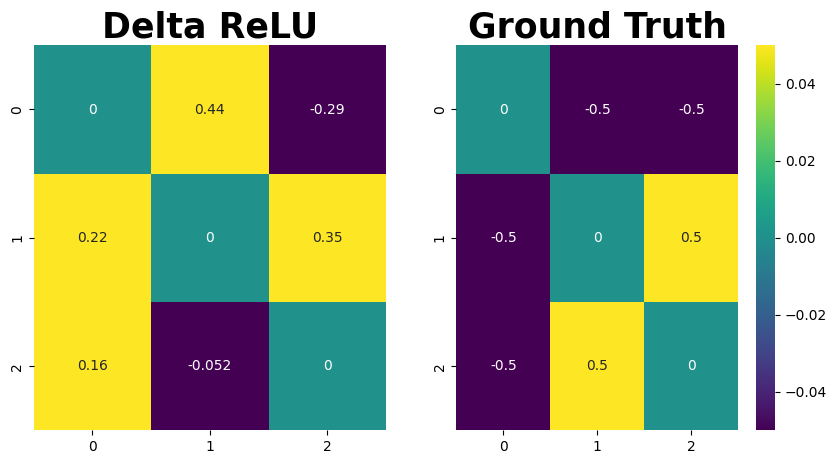

In [327]:

delta_relu = np.matmul(dCov2,B)
delta_relu_p = delta_relu.copy()
np.fill_diagonal(delta_relu_p,0)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(np.round(delta_relu_p,3), annot=True, cmap = 'viridis', vmin=-0.05, vmax=0.05, cbar = False, ax=axes[0])
axes[0].set_title("Delta ReLU", fontweight = "bold", fontsize = 25)
sns.heatmap(np.round(G,3), annot=True, cmap = 'viridis', vmin=-0.05, vmax=0.05, ax=axes[1])
axes[1].set_title("Ground Truth", fontweight = "bold", fontsize = 25)

Both functions from above could be improved - possibly regularization might improve recovery

## Linear Regularized DDC Estimation
ddc_l = linear regularized ddc


In [328]:
ddc_l = dCov_linear_Reg(V=V_pre, TR=deltaT)
ddc_l

array([[ 0.70195976, -0.53202543, -0.70706064],
       [-0.27722777, -0.13736268,  0.36052589],
       [-0.42473199,  0.66938811,  0.34653475]])

Text(0.5, 1.0, 'Ground Truth')

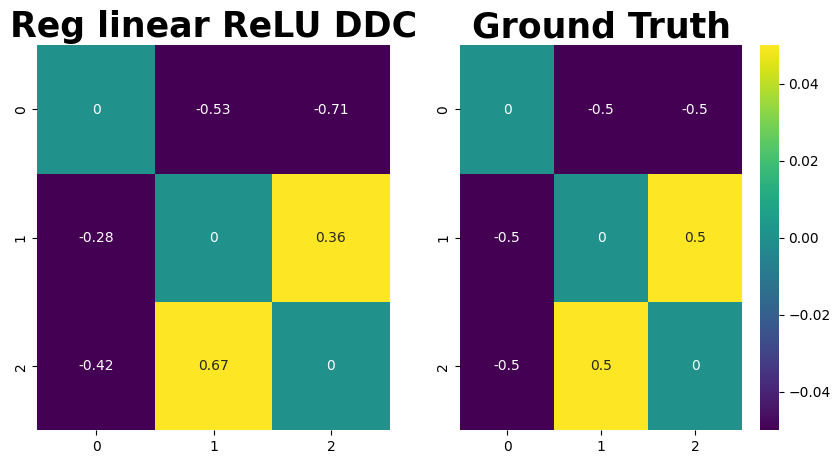

In [329]:
ddc_l_p = ddc_l.copy()
np.fill_diagonal(ddc_l_p,0)


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(np.round(ddc_l_p,3), annot=True, cmap = 'viridis', vmin=-0.05, vmax=0.05, cbar = False, ax=axes[0])
axes[0].set_title("Reg linear ReLU DDC", fontweight = "bold", fontsize = 25)
sns.heatmap(np.round(G,3), annot=True, cmap = 'viridis', vmin=-0.05, vmax=0.05, ax=axes[1])
axes[1].set_title("Ground Truth", fontweight = "bold", fontsize = 25)

The linear ddc perfomrs well - much better recovery than without regularization

## Regularized non-linear ddc estimation
* ddc_relu = regularized non-linear

In [330]:
ddc_relu = dcov_relu(V=V_pre, TR=deltaT)
ddc_relu

array([[ 0.69068468, -0.34784253, -0.68810007],
       [-0.21413259, -0.35923367,  0.48507739],
       [-0.4765521 ,  0.7070762 ,  0.20302268]])

### what we recovered - regularized non-linear (relu)

Text(0.5, 1.0, 'Ground Truth')

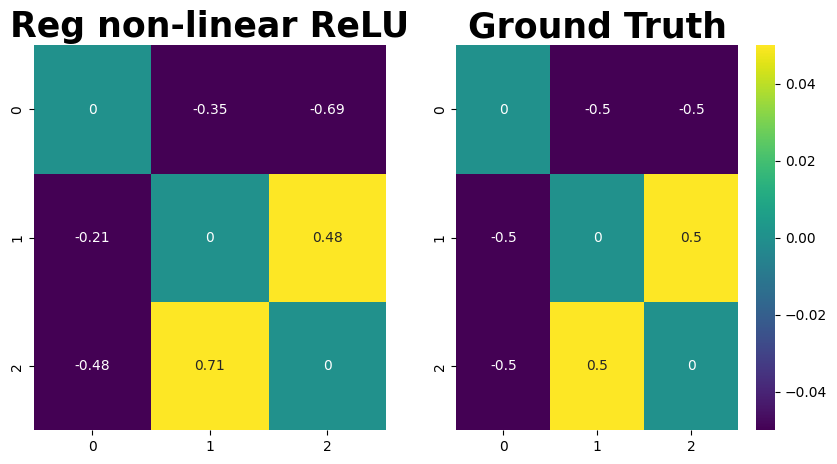

In [331]:
ddc_relu_p = ddc_relu.copy()
np.fill_diagonal(ddc_relu_p,0)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(np.round(ddc_relu_p,3), annot=True, cmap = 'viridis', vmin=-0.05, vmax=0.05, cbar = False, ax=axes[0])
axes[0].set_title("Reg non-linear ReLU", fontweight = "bold", fontsize = 25)
sns.heatmap(np.round(G,3), annot=True, cmap = 'viridis', vmin=-0.05, vmax=0.05, ax=axes[1])
axes[1].set_title("Ground Truth", fontweight = "bold", fontsize = 25)

This is much improved - we have slightly different intensities but we retain the same direction with slightly different intensities of our ground truth. This seems about the same as the linear regularized function - lets test similarity between ground truth and ddc recovery to determine which is better

# Evaluating recovery

## Representational similarity function to evaluate recovery

In [332]:
from joblib import parallel_backend

def distance(m1,m2):
  distance = []
  d_norm = []
  import numpy as np
  if len(m1) == len(m2) and m1[0].shape == m2[0].shape:
    for m in range(len(m1)):
      print("Calculating distance for pair", 1+m, "/", len(m1))
      mm = np.zeros([m1[m].shape[0],m1[m].shape[1]])
      for i in range(len(m1[m])):
        for j in range(len(m1[m][i])):
          mm[i][j] = (np.linalg.norm(m2[m][i][j] - m1[m][i][j]))
      distance.append(mm)
    for m in distance:
      mm2 = np.zeros([m.shape[1],m.shape[1]])
      for i in range(len(m)):
        for j in range(len(m[i])):
          mm2[i][j] = ((m[i][j]-np.min(m))/(np.max(m) - np.min(m)))
      d_norm.append(mm2)
    return(d_norm)
  else:
    raise Warning("list are different lengths or matricies are different sizes - please fix")



# function for converting distance to similarity matricies
def dist_to_sim(d_norm):
  sim = []
  for m in d_norm:
    print("Calculating similarity for", 1+len(sim), "/", len(d_norm))
    mm = np.zeros([m.shape[0],m.shape[1]])
    for i in range(len(m)):
      for j in range(len(m[i])):
        mm[i][j] = (((np.max(np.array(m))-np.min(np.array(m)))/2) - m[i][j])
    sim.append(mm)
  return(sim)



### Demonstrating representational similarity output


#### Very similar matrix = high similarity (nax = 0.5)

In [333]:
GG = np.array([[0, 0.5, 0.5],
              [0.5, 0, 0.5],
              [0.5, 0.5, 0]])
GG2 = np.array([[0, 0.5, 0.35],
              [0.45, 0, 0.5],
              [0.5, 0.5, 0]])
dist_G = distance([GG],[GG2])
sim_G = dist_to_sim(dist_G)
print("\n Similarity Matrix \n", pd.DataFrame(sim_G[0]))
print("\n Average Similarity = ", round(np.average(sim_G[0]),3))
print("\n Interpretation: \n Difference max = -0.5 \n Similarity max =  0.5 \n Unrelated  max =  0 ")

Calculating distance for pair 1 / 1
Calculating similarity for 1 / 1

 Similarity Matrix 
           0    1    2
0  0.500000  0.5 -0.5
1  0.166667  0.5  0.5
2  0.500000  0.5  0.5

 Average Similarity =  0.352

 Interpretation: 
 Difference max = -0.5 
 Similarity max =  0.5 
 Unrelated  max =  0 


#### Very different matrix = very low similarity (lowest is -0.5)

In [334]:
GG = np.array([[0, 0.5, 0.5],
              [0.5, 0, 0.5],
              [0.5, 0.5, 0]])
GG2 = np.array([[0.2, -0.5, -0.35],
              [-0.45, 0.1, -0.5],
              [-0.5, -0.5, 0.7]])
dist_G = distance([GG],[GG2])
sim_G = dist_to_sim(dist_G)
print("\n Similarity Matrix \n", pd.DataFrame(sim_G[0]))
print("\n Average Similarity = ", round(np.average(sim_G[0]),3))
print("\n Interpretation: \n Difference max = -0.5 \n Similarity max =  0.5 \n Unrelated  max =  0 ")

Calculating distance for pair 1 / 1
Calculating similarity for 1 / 1

 Similarity Matrix 
           0    1         2
0  0.388889 -0.5 -0.333333
1 -0.444444  0.5 -0.500000
2 -0.500000 -0.5 -0.166667

 Average Similarity =  -0.228

 Interpretation: 
 Difference max = -0.5 
 Similarity max =  0.5 
 Unrelated  max =  0 


### Calculating Similarity for each matrix

Ground truth we are trying to recover

In [335]:
G

array([[ 0. , -0.5, -0.5],
       [-0.5,  0. ,  0.5],
       [-0.5,  0.5,  0. ]])

#### Correlation similarity

In [336]:
dist_cor = distance([cor],[G])
sim_cor = dist_to_sim(dist_cor)
print("\n Similarity Matrix \n", pd.DataFrame(sim_cor[0]))
print("\n Average Similarity= ", round(np.average(sim_cor[0]),3))
print("\n Interpretation: \n Difference max = -0.5 \n Similarity max =  0.5 \n Unrelated  max =  0 ")

Calculating distance for pair 1 / 1
Calculating similarity for 1 / 1

 Similarity Matrix 
           0         1         2
0  0.500000 -0.033771 -0.500000
1 -0.033771  0.500000  0.014921
2 -0.500000  0.014921  0.500000

 Average Similarity=  0.051

 Interpretation: 
 Difference max = -0.5 
 Similarity max =  0.5 
 Unrelated  max =  0 


### Delta Relu

In [337]:
dist_ddr = distance([delta_relu],[G])
sim_ddr = dist_to_sim(dist_ddr)
print("\n Similarity Matrix \n", pd.DataFrame(sim_ddr[0]))
print("\n Average Similarity = ", round(np.average(sim_ddr[0]),3))
print("\n Interpretation: \n Difference max = -0.5 \n Similarity max =  0.5 \n Unrelated  max =  0 ")

Calculating distance for pair 1 / 1
Calculating similarity for 1 / 1

 Similarity Matrix 
           0         1         2
0  0.135466 -0.500000  0.332406
1 -0.243452  0.121710  0.396345
2 -0.184025 -0.057771  0.500000

 Average Similarity =  0.056

 Interpretation: 
 Difference max = -0.5 
 Similarity max =  0.5 
 Unrelated  max =  0 


Delta L

In [338]:
dist_ddl = distance([delta_l],[G])
sim_ddl = dist_to_sim(dist_ddl)
print("\n Similarity Matrix \n", pd.DataFrame(sim_ddl[0]))
print("\n Average Similarity = ", round(np.average(sim_ddl[0]),3))
print("\n Interpretation: \n Difference max = -0.5 \n Similarity max =  0.5 \n Unrelated  max =  0 ")

Calculating distance for pair 1 / 1
Calculating similarity for 1 / 1

 Similarity Matrix 
           0         1         2
0  0.165169  0.161990  0.165737
1  0.191553  0.500000  0.110922
2 -0.500000  0.299648 -0.361000

 Average Similarity =  0.082

 Interpretation: 
 Difference max = -0.5 
 Similarity max =  0.5 
 Unrelated  max =  0 


### Regularized Linear

In [339]:
dist_ddcl = distance([ddc_l],[G])
sim_ddcl = dist_to_sim(dist_ddcl)
print("\n Similarity Matrix \n", pd.DataFrame(sim_ddcl[0]))
print("\n Average Similarity = ", round(np.average(sim_ddcl[0]),3))
print("\n Interpretation: \n Difference max = -0.5 \n Similarity max =  0.5 \n Unrelated  max =  0 ")

Calculating distance for pair 1 / 1
Calculating similarity for 1 / 1

 Similarity Matrix 
           0         1         2
0 -0.500000  0.500000  0.238728
1  0.215275  0.342765  0.339613
2  0.435453  0.294961  0.030537

 Average Similarity =  0.211

 Interpretation: 
 Difference max = -0.5 
 Similarity max =  0.5 
 Unrelated  max =  0 


#### Regularized non-linear

In [340]:
dist_ddcr = distance([ddc_relu],[G])
sim_ddcr = dist_to_sim(dist_ddcr)
print("\n Similarity Matrix \n", pd.DataFrame(sim_ddcr[0]))
print("\n Average Similarity = ", round(np.average(sim_ddcr[0]),3))
print("\n Interpretation: \n Difference max = -0.5 \n Similarity max =  0.5 \n Unrelated  max =  0 ")

Calculating distance for pair 1 / 1
Calculating similarity for 1 / 1

 Similarity Matrix 
           0         1         2
0 -0.500000  0.296918  0.243730
1  0.099053 -0.009515  0.500000
2  0.487384  0.215649  0.221647

 Average Similarity =  0.173

 Interpretation: 
 Difference max = -0.5 
 Similarity max =  0.5 
 Unrelated  max =  0 


## Cosine similarity to evaluate recovery

### Correlation


In [341]:
print(cosine_similarity(cor, G))
np.average(cosine_similarity(cor, G))

[[-0.82967103  0.69396182  0.1357092 ]
 [ 0.35033964 -0.96455632 -0.61421669]
 [ 0.07838651 -0.70274857 -0.78113509]]


np.float64(-0.2926589462420968)

### Regularized linear DDC

In [342]:
print(cosine_similarity(ddc_l_p, G))
np.average(cosine_similarity(ddc_l_p, G))

[[ 0.99016947 -0.56502117 -0.4251483 ]
 [-0.56054481  0.99157789  0.43103308]
 [-0.59706011  0.37883931  0.97589942]]


np.float64(0.17997164286404382)

### Regularized non-linear DDC

In [343]:
print(cosine_similarity(ddc_relu_p, G))
np.average(cosine_similarity(ddc_relu_p, G))

[[ 0.95006536 -0.63105817 -0.31900719]
 [-0.6468816   0.93244104  0.28555944]
 [-0.58636292  0.39519429  0.98155721]]


np.float64(0.15127860797081005)

In [344]:
print(cosine_similarity(delta_l, G))
np.average(cosine_similarity(delta_l, G))

[[-0.73695465  0.8445379   0.84832833]
 [-0.41194248  0.98472993  0.34532642]
 [ 0.59784767 -0.98742747 -0.61220448]]


np.float64(0.09691568545208223)

In [345]:
print(cosine_similarity(delta_relu, G))
np.average(cosine_similarity(delta_relu, G))

[[-0.16159145  0.09255642  0.89040563]
 [ 0.05110982  0.16738093 -0.7561247 ]
 [ 0.42402683 -0.86209069 -0.84241585]]


np.float64(-0.11074923055766828)

## Conclusions

### Regularized version of ReLU perform best for recovering ground truth connectivity

## Both linear and non-linear ReLU activation function with regularization did well in recovering ground truth connectivity

1. **Non-Linear Regularized ReLU** was commensurately related to ground truth
  + this held for both cosine similarity and representational similarity with data that did not impose assumptions of linearity on their relationships.

2. **Linear Regularized ReLU** was also commensurately similar and did a much better job of recovery in this instance.

### Just to make sure our code does well - lets compare to a prior implementation

# Comparison to recovery from other's python implementation
[Repository](https://github.com/margotwagner/DDC/blob/main/src/py_DDC/FC_functions.py) direct import of version on 3/17/2025

In [346]:
import numpy as np
import pandas as pd
from numpy.linalg import inv
from scipy.stats import zscore
from numpy.linalg import matrix_rank
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
import sklearn

def test():
    print("yes")


def estimators(V_obs, thres, TR):
    T, N = np.shape(V_obs)
    Cov = np.cov(V_obs, rowvar=False)
    precision = inv(Cov)
    Fx = V_obs - thres
    Fx[Fx < 0] = 0
    tmp = np.hstack((Fx, V_obs))
    B_tmp = np.cov(tmp, rowvar=False)
    B = B_tmp[0:N, N:]
    dV = np.array(((-1 / 2 * V_obs[0:-2, :] + 1 / 2 * V_obs[2:, :])) / TR)
    rowmean = np.mean(dV, axis=0)
    dV = np.vstack([rowmean, dV, rowmean])
    tmp_2 = np.hstack((dV, V_obs))
    dCov = tmp_2[0:N, N + 1 :]

    return Cov, precision, B, dCov


def derivative_123(f, dm, dt):
    t = np.arange(dm, len(f) - dm)
    D1, D2, D3 = 0, 0, 0
    d1, d2, d3 = 0, 0, 0
    for n1 in range(1, dm + 1):
        # n1i = n1 - 1
        for n2 in range(n1 + 1, dm + 1):
            # n2i = n2 - 1
            d1 += 1
            D1 += -(
                (
                    f[t - n2] * n1**3
                    - f[t + n2] * n1**3
                    - f[t - n1] * n2**3
                    + f[t + n1] * n2**3
                )
                / (2 * dt * n1**3 * n2 - 2 * dt * n1 * n2**3)
            )
            """
            for n3 in range(n2 + 1, dm + 1):
                #n3i = n3-1
                d3 += 1
                D3 += (3 * (f[t - n3i] * n1 * n2 * (n1 ** 4 - n2 ** 4) +
                            f[t + n3i] * (-(n1 ** 5 * n2) + n1 * n2 ** 5) +
                            n3 * ((f[t - n1i] - f[t + n1i]) * n2 * (n2 ** 4 - n3 ** 4) +
                                  f[t + n2i] * (n1 ** 5 - n1 * n3 ** 4) + f[t - n2i] * (-n1 ** 5 + n1 * n3 ** 4)))) / \
                      (dt ** 3 * n1 * (n1 ** 2 - n2 ** 2) * n3 * (n1 ** 2 - n3 ** 2) * (n2 ** 3 - n2 * n3 ** 2))

            d2 += 1
            D2 += (f[t - n2i] * n1 ** 4 + f[t + n2i] * n1 ** 4 - f[t - n1i] * n2 ** 4 - f[t + n1i] * n2 ** 4 -
                   2 * f[t] * (n1 ** 4 - n2 ** 4)) / \
                  (dt ** 2 * n2 ** 2 * (n1 ** 4 - n1 ** 2 * n2 ** 2))
            """
    D1 = D1 / d1
    # D2 = D2 / d2
    # D3 = D3 / d3

    return D1, D2, D3


def dCov_numerical(cx, h, dm=4):
    T, N = np.shape(cx)
    diff_cx = np.array((cx[1:, :] - cx[0:-1, :]) / h)
    rowmean = np.mean(diff_cx, axis=0)
    diff_cx = np.vstack([diff_cx, rowmean])
    Csample = np.cov(np.hstack((diff_cx, cx)).T)
    dCov1 = Csample[0:N, N : N + N]

    diff_cx = np.array((1 / 2 * cx[2:, :] - (1 / 2 * cx[0:-2, :])) / h)
    rowmean = np.mean(diff_cx, axis=0)
    diff_cx = np.vstack([rowmean, diff_cx, rowmean])
    Csample = np.cov(np.hstack((diff_cx, cx)).T)
    dCov2 = Csample[0:N, N : N + N]

    diff_cx = np.array(
        (-cx[4:, :] + 8 * cx[3:-1, :] - 8 * cx[1:-3, :] + cx[:-4, :]) / (12 * h)
    )
    rowmean = np.mean(diff_cx, axis=0)
    diff_cx = np.vstack([rowmean, rowmean, diff_cx, rowmean, rowmean])
    Csample = np.cov(np.hstack((diff_cx, cx)).T)
    dCov5 = Csample[0:N, N : N + N]

    diff_cx = None
    for i in range(N):
        dx, _, _ = derivative_123(cx[:, i], dm, h)
        if diff_cx is None:
            diff_cx = dx
        else:
            diff_cx = np.c_[diff_cx, dx]
    cx_trunc = cx[dm : T - dm, :]
    Csample = np.cov(np.hstack((diff_cx, cx_trunc)).T)
    dCov_center = Csample[:N, N : N + N]

    return dCov1, dCov2, dCov5, dCov_center


def prctile(x, p):
    p = np.asarray(p, dtype=float)
    n = len(x)
    p = (p - 50) * n / (n - 1) + 50
    p = np.clip(p, 0, 100)

    return np.percentile(x, p)


def compute_ddc(ts, TR):
    # Input:
    # ts = time series (number of timepoints x number of nodes)
    # TR = time resolution
    # d = derivative to be used, either 2 for dCov2 or c for dCov_center
    # Output:
    # Cov = covariance matrix
    # DDC = dynamical differential covariance
    # Reg_DDC = regularized DDC
    # nl_DDC = non linear DDC estimator

    if np.max(ts[0, :]) == ts[0, -1] and np.min(ts[0, :]) == ts[0, 0]:
        ts = ts[1:, :]

    T, N = ts.shape
    V_obs = zscore(ts, ddof=1)
    dCov1, dCov2, _, dCov_center = dCov_numerical(V_obs, TR)
    Cov, Precision, B, _ = estimators(V_obs, 0, TR)

    if matrix_rank(Cov) < len(Cov):
        print("Cov is rank deficient!")
        qc_flag=1
    else:
        qc_flag=0

    # if d == 2:  # using dCov2
    DDC2 = dCov2 @ Precision  # Delta L
    nl_DDC2 = dCov2 @ B  # Delta ReLu

    C = dCov2
    B = Cov
    Reg_DDC2 = np.zeros(np.shape(C))

    l = 1e-2
    Bb = sklearn.preprocessing.scale(B)

    for n in range(len(C)):
        ci = C[n, :]
        ridgereg = Ridge(alpha=l)
        ridgereg.fit(Bb, ci.T)
        coef = ridgereg.coef_
        Reg_DDC2[n, :] = coef.T

    # elif d == "c":  # using dCov_center
    DDCc = dCov_center @ Precision  # Delta L
    nl_DDCc = dCov_center @ B  # Delta ReLu

    C = dCov_center
    B = Cov
    Reg_DDCc = np.zeros(np.shape(C))

    l = 1e-2
    Bb = sklearn.preprocessing.scale(B)
    for n in range(len(C)):
        ci = C[n, :]
        ridgereg = Ridge(alpha=l)
        ridgereg.fit(Bb, ci.T)
        coef = ridgereg.coef_
        Reg_DDCc[n, :] = coef.T

    return Cov, DDC2, Reg_DDC2, nl_DDC2, DDCc, Reg_DDCc, nl_DDCc, qc_flag



Text(0.5, 1.0, 'Ground Truth')

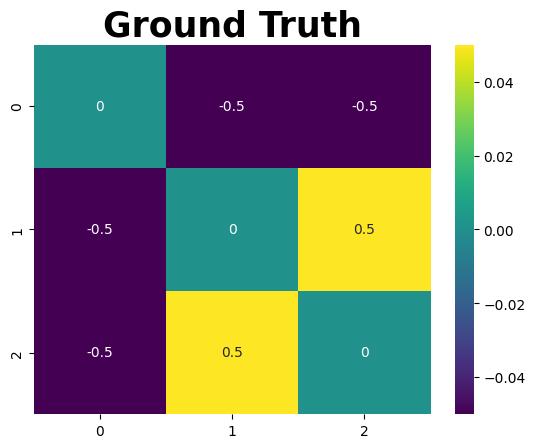

In [347]:
sns.heatmap(np.round(G,3), annot=True, cmap = 'viridis', vmin=-0.05, vmax=0.05)
plt.title("Ground Truth", fontweight = "bold", fontsize = 25)


In [348]:
Cov, DDC2, Reg_DDC2, nl_DDC2, DDCc, Reg_DDCc, nl_DDCc, qc_flag = compute_ddc(ts=V_pre, TR=deltaT)

Text(0.5, 1.0, 'Ground Truth')

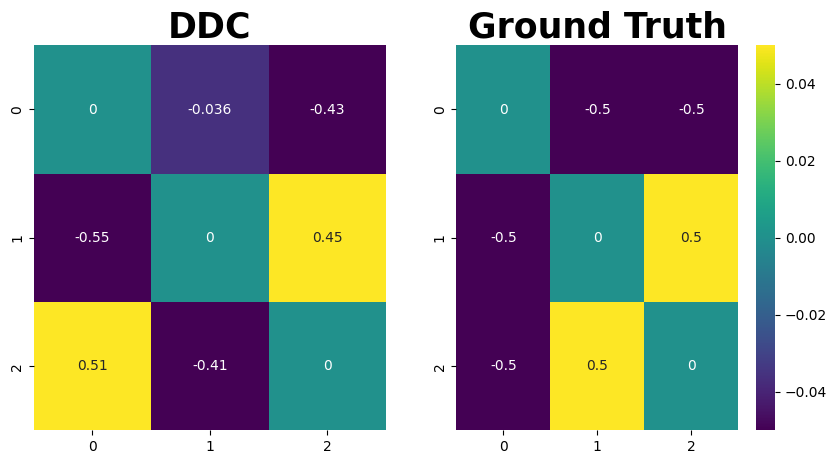

In [349]:
gg_p = DDC2.copy()*100
np.fill_diagonal(gg_p,0)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(np.round(gg_p,3), annot=True, cmap = 'viridis', vmin=-0.05, vmax=0.05, cbar = False, ax=axes[0])
axes[0].set_title("DDC", fontweight = "bold", fontsize = 25)
sns.heatmap(np.round(G,3), annot=True, cmap = 'viridis', vmin=-0.05, vmax=0.05, ax=axes[1])
axes[1].set_title("Ground Truth", fontweight = "bold", fontsize = 25)

Text(0.5, 1.0, 'Ground Truth')

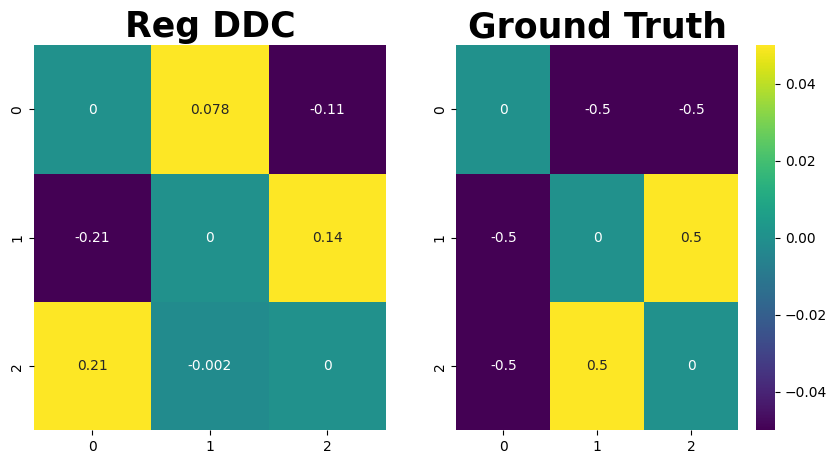

In [350]:
gg_p = Reg_DDC2.copy()*100
np.fill_diagonal(gg_p,0)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(np.round(gg_p,3), annot=True, cmap = 'viridis', vmin=-0.05, vmax=0.05, cbar = False, ax=axes[0])
axes[0].set_title("Reg DDC", fontweight = "bold", fontsize = 25)
sns.heatmap(np.round(G,3), annot=True, cmap = 'viridis', vmin=-0.05, vmax=0.05, ax=axes[1])
axes[1].set_title("Ground Truth", fontweight = "bold", fontsize = 25)

Text(0.5, 1.0, 'Ground Truth')

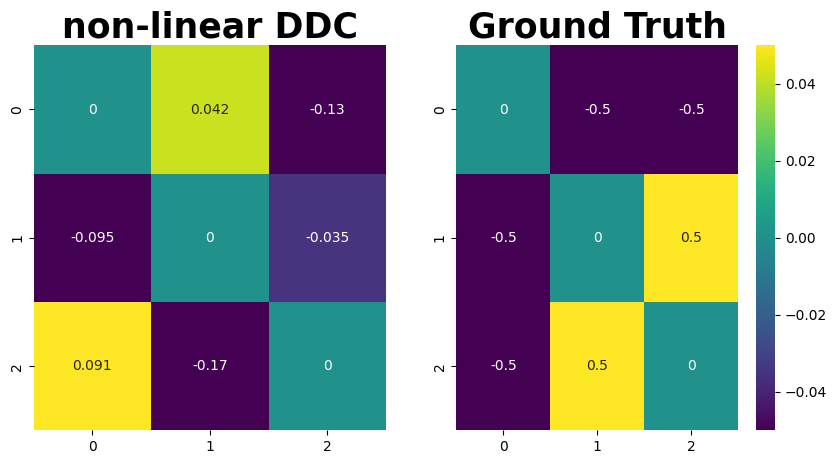

In [351]:
gg_p = nl_DDC2.copy()*100
np.fill_diagonal(gg_p,0)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(np.round(gg_p,3), annot=True, cmap = 'viridis', vmin=-0.05, vmax=0.05, cbar = False, ax=axes[0])
axes[0].set_title("non-linear DDC", fontweight = "bold", fontsize = 25)
sns.heatmap(np.round(G,3), annot=True, cmap = 'viridis', vmin=-0.05, vmax=0.05, ax=axes[1])
axes[1].set_title("Ground Truth", fontweight = "bold", fontsize = 25)

Text(0.5, 1.0, 'Ground Truth')

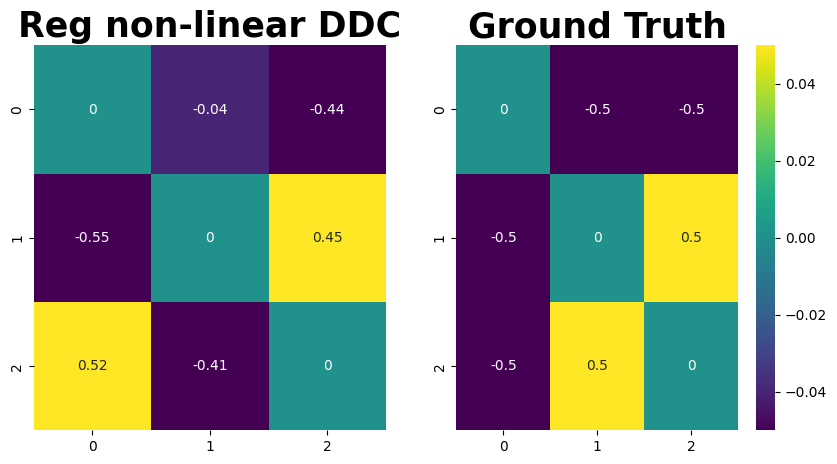

In [352]:
gg_p = DDCc.copy()*100
np.fill_diagonal(gg_p,0)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(np.round(gg_p,3), annot=True, cmap = 'viridis', vmin=-0.05, vmax=0.05, cbar = False, ax=axes[0])
axes[0].set_title("Reg non-linear DDC", fontweight = "bold", fontsize = 25)
sns.heatmap(np.round(G,3), annot=True, cmap = 'viridis', vmin=-0.05, vmax=0.05, ax=axes[1])
axes[1].set_title("Ground Truth", fontweight = "bold", fontsize = 25)

Text(0.5, 1.0, 'Ground Truth')

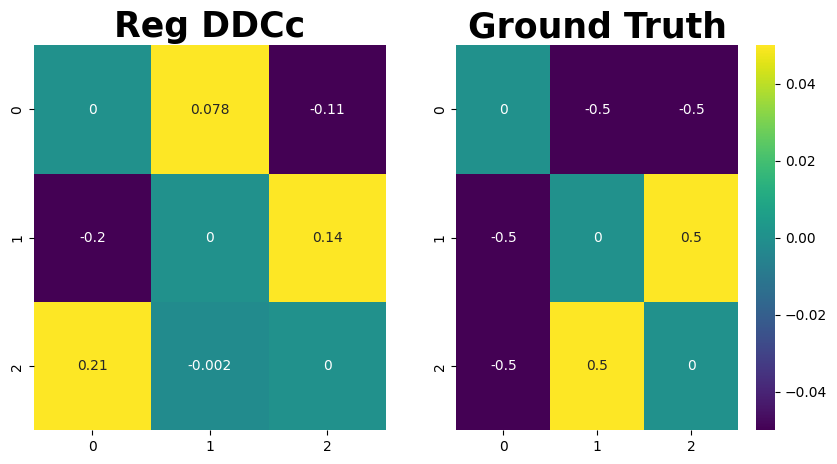

In [353]:
gg_p = Reg_DDCc.copy()*100
np.fill_diagonal(gg_p,0)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(np.round(gg_p,3), annot=True, cmap = 'viridis', vmin=-0.05, vmax=0.05, cbar = False, ax=axes[0])
axes[0].set_title("Reg DDCc", fontweight = "bold", fontsize = 25)
sns.heatmap(np.round(G,3), annot=True, cmap = 'viridis', vmin=-0.05, vmax=0.05, ax=axes[1])
axes[1].set_title("Ground Truth", fontweight = "bold", fontsize = 25)

Text(0.5, 1.0, 'Ground Truth')

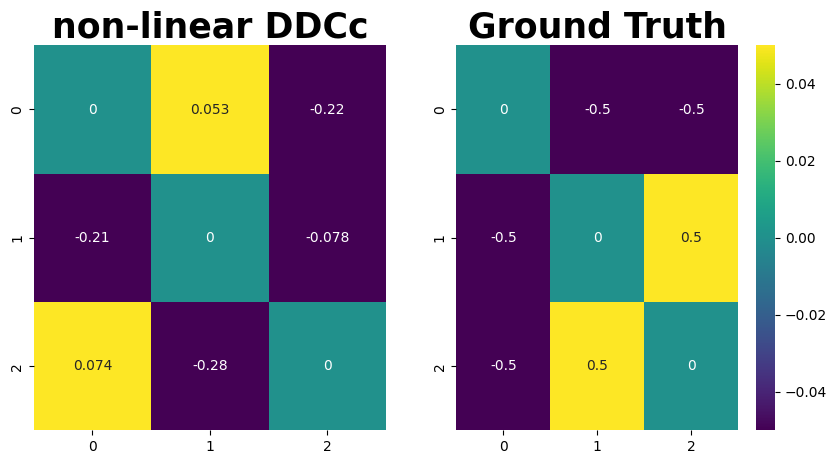

In [354]:
gg_p = nl_DDCc.copy()*100
np.fill_diagonal(gg_p,0)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(np.round(gg_p,3), annot=True, cmap = 'viridis', vmin=-0.05, vmax=0.05, cbar = False, ax=axes[0])
axes[0].set_title("non-linear DDCc", fontweight = "bold", fontsize = 25)
sns.heatmap(np.round(G,3), annot=True, cmap = 'viridis', vmin=-0.05, vmax=0.05, ax=axes[1])
axes[1].set_title("Ground Truth", fontweight = "bold", fontsize = 25)

## As demonstrated, this instatnation of the DDC in python did a poor job at recovery.

Given that this version of the code likely distorts the signal by early thresholding on the raw data, followed by a separate regularization step -- We improved on the implemnetation here that is reflected in imprved recovery

Why the Notebook Outperforms the other code

-  Order of Operations (ReLU and Regularization)
  + The notebook first applies the ReLU transformation and then regularizes the covariance matrices. This ensures that only the relevant (active) parts of the data contribute to the model.
  + The other code may not correctly preserve this order, leading to suboptimal estimation.

- Handling of Covariances
  + The notebook correctly computes both raw and differential covariances (dCov_numerical and estimators functions).
  + The other implementation might be improperly normalizing or computing dCov, leading to poor recovery.

-  Numerical Differentiation
  + The notebook applies multiple differentiation techniques (first-order, second-order, five-point stencil, and centered derivatives) in dCov_numerical(), ensuring more accurate estimates.
  + The other code might rely on simpler or less robust differentiation methods, leading to higher noise sensitivity.

- Regularization Approach
  + The notebook implements Ridge Regression explicitly in dCov_linear_Reg() and dcov_relu(), improving numerical stability.
  + The other code implementation might not properly regularize or may not balance lambda_ optimally.

-  Z-Scoring and Scaling
  + Standardization (z-scoring) is explicitly applied before processing, ensuring that all variables contribute equally.
  + This might be missing or incorrectly handled in the other code, leading to bias in estimated parameters.

In [356]:
%load_ext watermark
%watermark -n -u -v -iv -w -p numpy,pandas,matplotlib,seaborn,sklearn

Last updated: Mon Mar 17 2025

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 7.34.0

numpy     : 2.0.2
pandas    : 2.2.2
matplotlib: 3.10.0
seaborn   : 0.13.2
sklearn   : 1.6.1

matplotlib: 3.10.0
sklearn   : 1.6.1
pathlib   : 1.0.1
seaborn   : 0.13.2
sys       : 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
scipy     : 1.14.1
joblib    : 1.4.2
numpy     : 2.0.2
pandas    : 2.2.2
IPython   : 7.34.0
re        : 2.2.1

Watermark: 2.5.0

